## Analysis of model coefficients

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
pancancer_dir = os.path.join(cfg.results_dir, 'pancancer')
single_cancer_dir = os.path.join(cfg.results_dir, 'single_cancer')

For the pan-cancer experiments, we added covariates (e.g. fixed effects, dummy/one-hot encoded variables) for the cancer types present in the dataset.

Here, we want to look at the proportion of models in which the coefficient for these cancer type covariates. Are they mostly zero (since we're using elastic net regularization), or are they often informative? Does this differ between models that outperform the negative control and models that don't?

In [3]:
sample_info_df = du.load_sample_info()
tcga_cancer_types = list(np.unique(sample_info_df.cancer_type))

identifier_coefs_info = []
for identifier, coefs_list in au.generate_nonzero_coefficients(pancancer_dir):
    for fold_no, coefs in enumerate(coefs_list):
        cancer_covs = au.get_cancer_type_covariates(coefs, tcga_cancer_types)
        identifier_coefs_info.append((identifier, fold_no, len(cancer_covs), cancer_covs))
        
# TODO: do we need a way to generate list of all features?
ids_df = pd.DataFrame(identifier_coefs_info, columns=['identifier', 'fold', 'nz_cov_count', 'nz_covs'])
ids_df[ids_df.nz_cov_count > 0].head(n=10)

,identifier,fold,nz_cov_count,nz_covs
0,MAP3K1_BRCA,0,1,[BRCA]
9,MLH1_UCEC,1,1,[UCEC]
10,MLH1_UCEC,2,1,[UCEC]
160,CIC_SKCM,0,1,[LGG]
256,CBL_UCEC,0,1,[UCEC]
258,CBL_UCEC,2,1,[UCEC]
273,JAK3_OV,1,1,[UCEC]
277,H3F3A_BRCA,1,1,[BRCA]
280,H3F3A_LIHC,0,1,[BRCA]
315,MAP2K1_SKCM,3,1,[SKCM]


In [4]:
# load significant identifiers and join into coefficients dataframe
# pancancer_comparison_df = pd.read_csv(os.path.join(cfg.results_dir, 'pancancer_pvals.tsv'),
#                                       index_col=False, sep='\t')
results_dir = '/home/jake/data/pancancer_vogelstein_09_25'
pancancer_comparison_df = pd.read_csv(os.path.join(results_dir, 'pancancer_pvals.tsv'),
                                      index_col=False, sep='\t')
merge_df = (
    ids_df.merge(pancancer_comparison_df, left_on='identifier', right_on='identifier')
          .drop(columns=['delta_mean', 'p_value', 'corr_pval', 'nlog10_p'])
)
merge_df.head(n=8)

,identifier,fold,nz_cov_count,nz_covs,reject_null
0,MAP3K1_BRCA,0,1,[BRCA],True
1,MAP3K1_BRCA,1,0,[],True
2,MAP3K1_BRCA,2,0,[],True
3,MAP3K1_BRCA,3,0,[],True
4,MAP3K1_UCEC,0,0,[],False
5,MAP3K1_UCEC,1,0,[],False
6,MAP3K1_UCEC,2,0,[],False
7,MAP3K1_UCEC,3,0,[],False


Text(0, 0.5, 'Number of models (fold/cancer type/gene)')

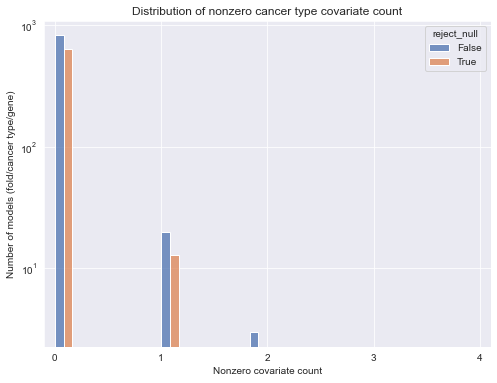

In [5]:
sns.set({'figure.figsize': (8, 6)})
sns.histplot(data=merge_df, x='nz_cov_count', hue='reject_null', log_scale=(False, True),
             kde=False, multiple='dodge')
plt.xticks(range(0, 5))
plt.xlim(-0.1, 4.1)
plt.title('Distribution of nonzero cancer type covariate count')
plt.xlabel('Nonzero covariate count')
plt.ylabel('Number of models (fold/cancer type/gene)')

So, it looks like the cancer type covariates are largely unused by the models, and the proportion of models using them doesn't seem to vary much between well-performing and poorly-performing models.

Now we want to do something similar for the sample mutation burden covariate ("log10_mut").

In [6]:
identifier_mut_coefs = []
for identifier, coefs_list in au.generate_nonzero_coefficients(pancancer_dir):
    for fold_no, coefs in enumerate(coefs_list):
        mut_cov = au.get_mutation_covariate(coefs)
        identifier_mut_coefs.append((identifier, fold_no, mut_cov))
        
mut_ids_df = pd.DataFrame(identifier_mut_coefs, columns=['identifier', 'fold', 'mut_cov'])
mut_ids_df.head(n=10)

mut_merge_df = (
    mut_ids_df.merge(pancancer_comparison_df, left_on='identifier', right_on='identifier')
              .drop(columns=['delta_mean', 'p_value', 'corr_pval', 'nlog10_p'])
)
mut_merge_df.head(n=8)

,identifier,fold,mut_cov,reject_null
0,MAP3K1_BRCA,0,True,True
1,MAP3K1_BRCA,1,True,True
2,MAP3K1_BRCA,2,False,True
3,MAP3K1_BRCA,3,True,True
4,MAP3K1_UCEC,0,False,False
5,MAP3K1_UCEC,1,True,False
6,MAP3K1_UCEC,2,True,False
7,MAP3K1_UCEC,3,False,False


/home/jake/anaconda3/envs/pancancer-evaluation/lib/python3.6/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


Text(0, 0.5, 'Number of models (fold/cancer type/gene)')

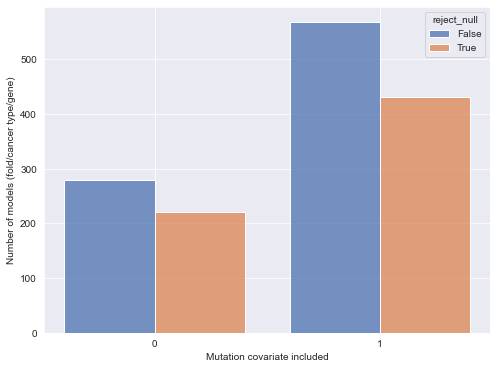

In [7]:
sns.set({'figure.figsize': (8, 6)})
sns.histplot(data=mut_merge_df, x='mut_cov', hue='reject_null',
             kde=False, discrete=True, multiple='dodge', shrink=.8)
plt.xticks((0, 1))
plt.xlabel('Mutation covariate included')
plt.ylabel('Number of models (fold/cancer type/gene)')

We can see that the mutation burden covariate is included in our models fairly frequently, more than half the time. It also seems to be zeroed out more often in well-performing models than poorly-performing models. This makes sense: in the case where a mutation doesn't result in a gene expression perturbation, there should be a bit of predictive signal in mutation burden, but in the case where a mutation perturbs gene expression noticeably, signal in the mutation burden should be at least somewhat redundant to the signal in the expression data (at least in some cases).

Last, we want to look at the genes selected by elastic net. The underlying question is: are most of the genes selected the most variable ones (i.e. have a high mean absolute deviation), or is the model selecting less variable genes in some cases? Again, we'll segment by well-performing/poorly-performing and see if we notice a difference.

In [8]:
# how stable are models between folds?
#
# we can quantify this using Jaccard similarity: treat coefficients as
# binary vectors (either 0 or 1=nonzero), and evaluate overlap
# between nonzero coefficients

per_fold_jaccard = []
for identifier, coefs_list in au.generate_nonzero_coefficients(pancancer_dir):
    # for each pairwise fold comparison, calculate jaccard index
    num_folds = len(coefs_list)
    for f1, f2 in it.combinations(range(num_folds), 2):
        try:
            nonzero_coefs_f1 = list(zip(*coefs_list[f1]))[0]
            nonzero_coefs_f2 = list(zip(*coefs_list[f2]))[0]
            inter_fold_jaccard, _, __ = au.compute_jaccard(nonzero_coefs_f1, nonzero_coefs_f2)
        except IndexError:
            # this can occur if all coefficients for a given fold were zero
            # (i.e. model predicts the mean/fits only an intercept)
            # if so, we call it a jaccard index of 0
            inter_fold_jaccard = 0.0
        per_fold_jaccard.append((identifier, f1, f2, inter_fold_jaccard))
    
intra_jaccard_df = pd.DataFrame(per_fold_jaccard, columns=['identifier', 'f1', 'f2', 'jaccard'])
intra_jaccard_df.head(n=10)

,identifier,f1,f2,jaccard
0,MAP3K1_BRCA,0,1,0.193237
1,MAP3K1_BRCA,0,2,0.012739
2,MAP3K1_BRCA,0,3,0.162047
3,MAP3K1_BRCA,1,2,0.008721
4,MAP3K1_BRCA,1,3,0.268166
5,MAP3K1_BRCA,2,3,0.007595
6,MAP3K1_UCEC,0,1,0.201087
7,MAP3K1_UCEC,0,2,0.201592
8,MAP3K1_UCEC,0,3,0.028490
9,MAP3K1_UCEC,1,2,0.331081


Text(0, 0.5, 'Bin count')

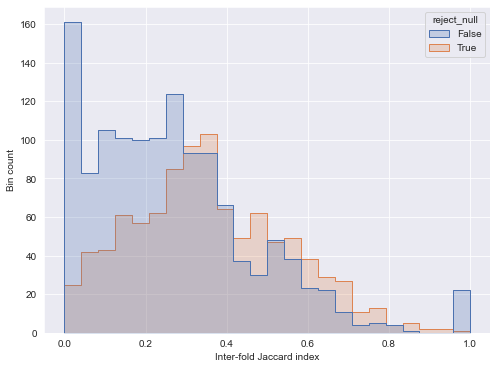

In [9]:
intra_jaccard_merge_df = (
    intra_jaccard_df.merge(pancancer_comparison_df, left_on='identifier', right_on='identifier')
                    .drop(columns=['delta_mean', 'p_value', 'corr_pval', 'nlog10_p'])
)
sns.set({'figure.figsize': (8, 6)})
sns.histplot(data=intra_jaccard_merge_df, x='jaccard', stat='count',
             hue='reject_null', element='step', kde=False)
plt.xlabel('Inter-fold Jaccard index')
plt.ylabel('Bin count')

In [10]:
# how stable are models between cancer types for the same gene?
genes_df = du.load_vogelstein()

inter_cancer_jaccard_df = None
for _, gene_series in genes_df.iterrows():
    gene = gene_series.gene
    per_gene_jaccard = {}
    for identifier, coefs_list in au.generate_nonzero_coefficients_for_gene(
                                                    pancancer_dir, gene):
        per_gene_jaccard[identifier] = coefs_list
    results_df = au.compare_inter_cancer_coefs(gene, per_gene_jaccard,
                                               pancancer_comparison_df)
    if inter_cancer_jaccard_df is None:
        inter_cancer_jaccard_df = results_df
    else:
        inter_cancer_jaccard_df = pd.concat((inter_cancer_jaccard_df, results_df))
            
print(inter_cancer_jaccard_df.shape)
inter_cancer_jaccard_df.head(n=10)    

(1375, 4)


,id1,id2,mean_jaccard,reject_null
0,ALK_LUAD,ALK_SKCM,0.022888,one
1,ALK_LUAD,ALK_COAD,0.023963,none
2,ALK_LUAD,ALK_UCEC,0.067173,none
3,ALK_SKCM,ALK_COAD,0.005942,one
4,ALK_SKCM,ALK_UCEC,0.121963,one
5,ALK_COAD,ALK_UCEC,0.029938,none
0,APC_SKCM,APC_UCEC,0.192374,none
1,APC_SKCM,APC_BLCA,0.243942,none
2,APC_SKCM,APC_STAD,0.231323,none
3,APC_SKCM,APC_HNSC,0.180466,none


Text(0, 0.5, 'Bin count')

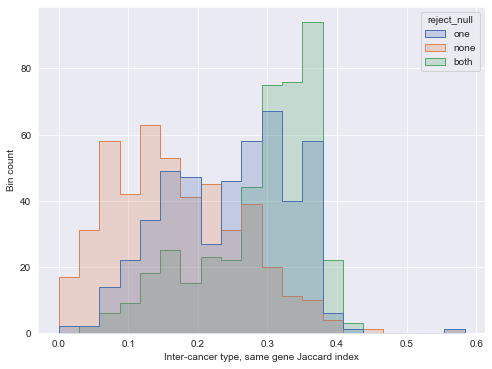

In [13]:
sns.set({'figure.figsize': (8, 6)})
sns.histplot(data=inter_cancer_jaccard_df, x='mean_jaccard', stat='count',
             hue='reject_null', element='step', kde=False)
plt.xlabel('Inter-cancer type, same gene Jaccard index')
plt.ylabel('Bin count')